In [1]:
import pandas as pd
import numpy as np
import pickle
import networkx as nx
import datetime
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

# Load data

In [2]:
df = pd.read_csv('../data/preprocessed_data.csv')
df = df[['topic_id', 'paper_id', 'affiliation_id', 'country_id']]

In [3]:
with open('../data/papers_with_pid.pkl', 'rb') as f:
    df_papers = pickle.load(f)

In [4]:
df_papers['Publication Month'] = [d.split()[0] for d in df_papers['Publication Date']]

df_former = df_papers.loc[df_papers['Publication Year'].isin((2018, 2019))]
df_former = pd.concat([df_former, df_papers.loc[df_papers['Publication Year']==2020].loc[df_papers['Publication Month'].isin(['JAN','FEB','MAR','APR','MAY','JUN'])]])

df_latter = df_papers.loc[df_papers['Publication Year'].isin((2021, 2022))]
df_latter = pd.concat([df_latter, df_papers.loc[df_papers['Publication Year']==2020].loc[df_papers['Publication Month'].isin(['JUL','AUG','SEP','OCT','NOV','DEC'])]])

In [5]:
df_f = df.loc[df.paper_id.isin(df_former.paper_id)]

In [6]:
df_l = df.loc[df.paper_id.isin(df_latter.paper_id)]

pid2topic, pid2prob = pd.read_pickle('../data/bertopic_topics_for_p2.pkl')
df_l['topic_id'] = [pid2topic[pid] for pid in df_l.paper_id]

df_l = df_l.loc[df_l.topic_id!=-1]

C:\Users\admin\AppData\Local\Temp\ipykernel_14328\3623739082.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_l['topic_id'] = [pid2topic[pid] for pid in df_l.paper_id]


In [7]:
aff_former = set(df_f.affiliation_id.unique())
aff_latter = set(df_l.affiliation_id.unique())
aff_both = set([aff for aff in aff_former if aff in aff_latter])
aff_both = sorted(aff_both)

In [8]:
with open('../data/aff2grid.pkl', 'rb') as f:
    aff2grid = pickle.load(f)

with open('../data/aid2affiliation.pkl', 'rb') as f:
    aid2aff = pickle.load(f)

topic_labels = pd.read_excel('../data/topic_labels.xlsx')

# Construct network for Period 2

In [9]:
tp_aff = df_l[['paper_id', 'affiliation_id']].drop_duplicates().groupby('affiliation_id').count().reset_index()
# aff_list = list(tp_aff.affiliation_id.unique())
aff_list_l = list(tp_aff.loc[tp_aff.paper_id>=10].affiliation_id.unique())
aff_list_l.sort()
len(aff_list_l)

1824

In [10]:
nodes_l = []
nodes_l += [f't{i}' for i in df_l.topic_id.unique()]
nodes_l += [f'p{i}' for i in df_l.paper_id.unique()]
nodes_l += [f'f{i}' for i in df_l.affiliation_id.unique()]
nodes_l += [f'c{i}' for i in df_l.country_id.unique()]

node2idx_l = {node: idx for idx, node in enumerate(nodes_l)}
idx2node_l = {idx: node for node, idx in node2idx_l.items()}

In [11]:
edges = ['topic_paper', 'topic_affiliation', 'topic_country', 
         'paper_affiliation', 'paper_country', 
         'affiliation_affiliation', 'affiliation_country',
         'country_country']
edge2idx = {edge: idx for idx, edge in enumerate(edges)}
idx2edge = {idx: edge for edge, idx in edge2idx.items()}

In [12]:
df_paper_aff = df_l[['paper_id', 'affiliation_id']].drop_duplicates()
collab = [list(df_paper_aff.loc[df_paper_aff.paper_id==p_id].affiliation_id) for p_id in df_paper_aff.paper_id.unique()]

collab_dict = {}
for i, c in enumerate(collab):
    if len(c)>=2:
        for comb in list(combinations(c, 2)):
            if comb in collab_dict.keys():
                collab_dict[comb] += 1
            else:
                collab_dict[comb] = 1

In [13]:
df_paper_cntr = df_l[['paper_id', 'country_id']].drop_duplicates()
collab = [list(df_paper_cntr.loc[df_paper_cntr.paper_id==p_id].country_id) for p_id in df_paper_cntr.paper_id.unique()]

cntr_collab_dict = {}
for i, c in enumerate(collab):
    if len(c)>=2:
        for comb in list(combinations(c, 2)):
            if comb in cntr_collab_dict.keys():
                cntr_collab_dict[comb] += 1
            else:
                cntr_collab_dict[comb] = 1

In [14]:
G_l = nx.Graph()

for i, (tid, pid) in enumerate(df_l[['topic_id', 'paper_id']].drop_duplicates().values):
    G_l.add_edge(f't{tid}', f'p{pid}', link_type='topic_paper')

for i, (tid, fid) in enumerate(df_l[['topic_id', 'paper_id', 'affiliation_id']].drop_duplicates()[['topic_id', 'affiliation_id']].values):
    G_l.add_edge(f't{tid}', f'f{fid}', link_type='topic_affiliation')

for i, (tid, cid) in enumerate(df_l[['topic_id', 'paper_id', 'affiliation_id', 'country_id']].drop_duplicates()[['topic_id', 'country_id']].values):
    G_l.add_edge(f't{tid}', f'c{cid}', link_type='topic_country')
    
for i, (pid, fid) in enumerate(df_l[['paper_id', 'affiliation_id']].drop_duplicates().values):
    G_l.add_edge(f'p{pid}', f'f{fid}', link_type='paper_affiliation')
    
for i, (pid, cid) in enumerate(df_l[['paper_id', 'country_id']].drop_duplicates().values):
    G_l.add_edge(f'p{pid}', f'c{cid}', link_type='paper_country')
        
for k, v in collab_dict.items():
    for _ in range(v):
        G_l.add_edge(f'f{k[0]}', f'f{k[1]}', link_type='affiliation_affiliation')

for i, (fid, cid) in enumerate(df_l[['affiliation_id', 'country_id']].drop_duplicates().values):
    G_l.add_edge(f'f{fid}', f'c{cid}', link_type='affiliation_country')
    
for k, v in cntr_collab_dict.items():
    for _ in range(v):
        G_l.add_edge(f'c{k[0]}', f'c{k[1]}', link_type='country_country')

# Recommend open innovation opportunities
* Before conduct recommendation, network embedding (data/entities_DeepWalk_p2.pkl) should be conducted.

## Task 1
* Recommend collaboration partners
* sim(target organization, recommended organization) + sim(target topic, recommended organization)

In [15]:
aid = 22  # index of the target organization
tid = 10  # index of the target topic

model = 'DeepWalk'
with open(f'../data/entities_{model}_p2.pkl', 'rb') as f:
    entities = pickle.load(f)

topic_vec = np.array([list(entities[str(node2idx_l[f't{tid}'])]) for tid in range(63)])
aff_vec = np.array([list(entities[str(node2idx_l[f'f{aid}'])]) for aid in aff_list_l])

aff_sim = cosine_similarity(aff_vec[aff_list_l.index(22)].reshape(1,-1), aff_vec)[0]
topic_sim = cosine_similarity(topic_vec[10].reshape(1,-1), aff_vec)[0]

total_sim = 1/3*aff_sim + 2/3*topic_sim
for idx in np.argsort(total_sim)[::-1][0:31]:
    print(f'{total_sim[idx]:.4f} {aff_list_l[idx]} {aid2aff[aff_list_l[idx]]}')

0.4397 3929 daimler ag
0.4393 22 united states department of energy (doe)
0.3813 23 argonne national laboratory
0.3742 3944 bosch
0.3619 2832 volkswagen
0.3443 2833 volkswagen germany
0.3418 3559 ford motor company
0.3400 34 idaho national laboratory
0.3350 81 national renewable energy laboratory - usa
0.3316 3934 bmw ag
0.3316 75 lawrence berkeley national laboratory
0.3297 25 slac national accelerator laboratory
0.3258 162 sandia national laboratories
0.3239 194 oak ridge national laboratory
0.3137 33 pacific northwest national laboratory
0.3027 193 brookhaven national laboratory
0.2961 24 stanford university
0.2924 227 temple university
0.2862 1885 hunan institute of engineering
0.2826 2047 university of paderborn
0.2816 4667 nagaoka university of technology
0.2802 2554 capital normal university
0.2796 433 san diego state university
0.2790 1354 hubei university of technology
0.2785 606 university of shanghai for science & technology
0.2754 3411 european synchrotron radiation facilit

In [16]:
candidate_aid = 2832  # select candidate organization
candidate = f'f{candidate_aid}'
target = f'f{aid}'

### Publications

In [17]:
# recent publications by the selected candidate
df_papers.loc[df_papers.paper_id.isin(set(df_f.loc[df_f.affiliation_id==candidate_aid].paper_id.unique())|set(df_l.loc[df_l.affiliation_id==candidate_aid].paper_id.unique()))].sort_values('Publication Year', ascending=False)[['Source Title', 'Article Title', 'Publication Year', 'Times Cited, All Databases']]

,Source Title,Article Title,Publication Year,"Times Cited, All Databases"
6741,ENERGY STRATEGY REVIEWS,Are the EU climate ambitions reflected on memb...,2022,5
60097,JOURNAL OF ENERGY STORAGE,Experimental study of cell integrated heat pip...,2022,1
67036,JOURNAL OF POWER SOURCES,Diagnosis tools for humidity-born surface cont...,2022,4
65313,JOURNAL OF POWER SOURCES,Oxygen reduction reaction measurements on plat...,2022,3
62344,JOURNAL OF ENERGY STORAGE,Correct water content measuring of lithium-ion...,2022,9
62126,JOURNAL OF ENERGY STORAGE,Holistic battery system design optimization fo...,2022,5
61575,JOURNAL OF ENERGY STORAGE,Virtual experiments for battery state of healt...,2022,18
61006,JOURNAL OF ENERGY STORAGE,Optimization strategy for coupled battery syst...,2022,1
61051,JOURNAL OF ENERGY STORAGE,State of health forecasting of Lithium-ion bat...,2021,9
63761,JOURNAL OF POWER SOURCES,Thermal fault detection by changes in electric...,2021,10


In [18]:
# top-cited publications by the selected candidate
df_papers.loc[df_papers.paper_id.isin(set(df_f.loc[df_f.affiliation_id==candidate_aid].paper_id.unique())|set(df_l.loc[df_l.affiliation_id==candidate_aid].paper_id.unique()))].sort_values('Times Cited, All Databases', ascending=False)[['Source Title', 'Article Title', 'Publication Year', 'Times Cited, All Databases']]

,Source Title,Article Title,Publication Year,"Times Cited, All Databases"
93782,NATURE ENERGY,Benchmarking the performance of all-solid-stat...,2020,556
57961,JOURNAL OF ENERGY STORAGE,Thermal runaway and thermal runaway propagatio...,2019,55
61492,JOURNAL OF ENERGY STORAGE,Investigation of significant capacity recovery...,2019,51
58268,JOURNAL OF ENERGY STORAGE,Investigation of the influence of different br...,2019,39
60234,JOURNAL OF ENERGY STORAGE,Identification of Li ion battery cell aging me...,2019,23
69545,JOURNAL OF POWER SOURCES,Transient limiting current measurements for ch...,2018,19
48606,APPLIED ENERGY,Load profile analysis for reducing energy dema...,2019,18
61575,JOURNAL OF ENERGY STORAGE,Virtual experiments for battery state of healt...,2022,18
45903,APPLIED ENERGY,Assessment of flexible electric vehicle chargi...,2020,13
60551,JOURNAL OF ENERGY STORAGE,Holistic calendar aging model parametrization ...,2020,12


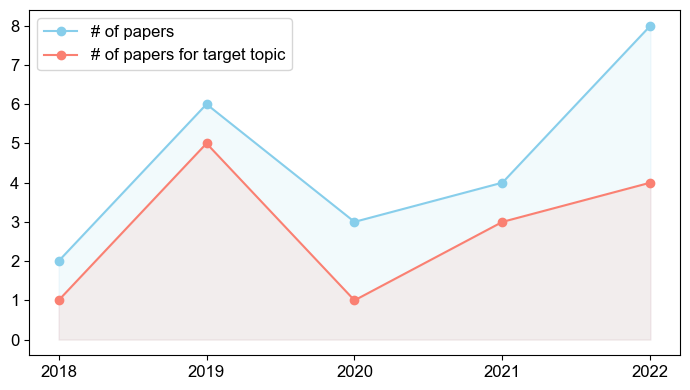

In [19]:
# publication trends for the selected candidate
n_pap_by_year = df_papers.loc[df_papers.paper_id.isin(set(df_f.loc[df_f.affiliation_id==candidate_aid].paper_id.unique())|set(df_l.loc[df_l.affiliation_id==candidate_aid].paper_id.unique()))].sort_values('Times Cited, All Databases', ascending=False)[['paper_id', 'Publication Year']].groupby('Publication Year').count().reset_index()

df_tp = pd.concat([df_f, df_l])
n_topic_pap_by_year = df_papers.loc[df_papers.paper_id.isin(df_tp.loc[df_tp.affiliation_id==candidate_aid].loc[df_tp.topic_id==10].paper_id.unique())][['paper_id', 'Publication Year']].groupby('Publication Year').count().reset_index()

plt.figure(figsize=(7, 4))
plt.plot(n_pap_by_year['Publication Year'], n_pap_by_year['paper_id'], color='skyblue', marker='o', label='# of papers')
plt.fill_between(n_pap_by_year['Publication Year'], n_pap_by_year['paper_id'], color='skyblue', alpha=0.1)
plt.plot(n_topic_pap_by_year['Publication Year'], n_topic_pap_by_year['paper_id'], color='salmon', marker='o', label='# of papers for target topic')
plt.fill_between(n_topic_pap_by_year['Publication Year'], n_topic_pap_by_year['paper_id'], color='salmon', alpha=0.1)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks([2018, 2019, 2020, 2021, 2022], fontsize=12)
plt.tight_layout()
plt.show()

### Network indices

In [20]:
CC = nx.clustering(G_l)
DC = nx.degree_centrality(G_l)
EC = nx.eigenvector_centrality(G_l)
PR = nx.pagerank(G_l)
TR = nx.triangles(G_l)

In [21]:
comparing_aids = [3929, 3944, 3559]  # select organizations to compare with the candidate

In [22]:
cc_list = [CC[f'f{aid}'] for aid in [candidate_aid]+comparing_aids]
dc_list = [DC[f'f{aid}'] for aid in [candidate_aid]+comparing_aids]
ec_list = [EC[f'f{aid}'] for aid in [candidate_aid]+comparing_aids]
pr_list = [PR[f'f{aid}'] for aid in [candidate_aid]+comparing_aids]
tr_list = [TR[f'f{aid}'] for aid in [candidate_aid]+comparing_aids]

aa_list = [list(nx.adamic_adar_index(G_l, ebunch=[(target, f'f{aid}')]))[0][2] for aid in  [candidate_aid]+comparing_aids if f'f{aid}'!=target]
jc_list = [list(nx.jaccard_coefficient(G_l, ebunch=[(target, f'f{aid}')]))[0][2] for aid in  [candidate_aid]+comparing_aids if f'f{aid}'!=target]
pa_list = [list(nx.preferential_attachment(G_l, ebunch=[(target, f'f{aid}')]))[0][2] for aid in  [candidate_aid]+comparing_aids if f'f{aid}'!=target]
ra_list = [list(nx.resource_allocation_index(G_l, ebunch=[(target, f'f{aid}')]))[0][2] for aid in  [candidate_aid]+comparing_aids if f'f{aid}'!=target]

In [23]:
indices_candidate = [
    (CC[candidate]-min(cc_list))/(max(cc_list)-min(cc_list)),
    (DC[candidate]-min(dc_list))/(max(dc_list)-min(dc_list)),
    (EC[candidate]-min(ec_list))/(max(ec_list)-min(ec_list)),
    (PR[candidate]-min(pr_list))/(max(pr_list)-min(pr_list)),
    (TR[candidate]-min(tr_list))/(max(tr_list)-min(tr_list)),
    (list(nx.adamic_adar_index(G_l, ebunch=[(target, candidate)]))[0][2]-min(aa_list))/(max(aa_list)-min(aa_list)),
    (list(nx.jaccard_coefficient(G_l, ebunch=[(target, candidate)]))[0][2]-min(jc_list))/(max(jc_list)-min(jc_list)),
    (list(nx.preferential_attachment(G_l, ebunch=[(target, candidate)]))[0][2]-min(pa_list))/(max(pa_list)-min(pa_list)),
    (list(nx.resource_allocation_index(G_l, ebunch=[(target, candidate)]))[0][2]-min(ra_list))/(max(ra_list)-min(ra_list)),
    (CC[candidate]-min(cc_list))/(max(cc_list)-min(cc_list)),
]

In [24]:
indices_compare = {}
for aid in comparing_aids:
    indices_tp = [
        (CC[f'f{aid}']-min(cc_list))/(max(cc_list)-min(cc_list)),
        (DC[f'f{aid}']-min(dc_list))/(max(dc_list)-min(dc_list)),
        (EC[f'f{aid}']-min(ec_list))/(max(ec_list)-min(ec_list)),
        (PR[f'f{aid}']-min(pr_list))/(max(pr_list)-min(pr_list)),
        (TR[f'f{aid}']-min(tr_list))/(max(tr_list)-min(tr_list)),
        (list(nx.adamic_adar_index(G_l, ebunch=[(target, f'f{aid}')]))[0][2]-min(aa_list))/(max(aa_list)-min(aa_list)),
        (list(nx.jaccard_coefficient(G_l, ebunch=[(target, f'f{aid}')]))[0][2]-min(jc_list))/(max(jc_list)-min(jc_list)),
        (list(nx.preferential_attachment(G_l, ebunch=[(target, f'f{aid}')]))[0][2]-min(pa_list))/(max(pa_list)-min(pa_list)),
        (list(nx.resource_allocation_index(G_l, ebunch=[(target, f'f{aid}')]))[0][2]-min(ra_list))/(max(ra_list)-min(ra_list)),
        (CC[f'f{aid}']-min(cc_list))/(max(cc_list)-min(cc_list)),
    ]
    indices_compare[aid] = indices_tp

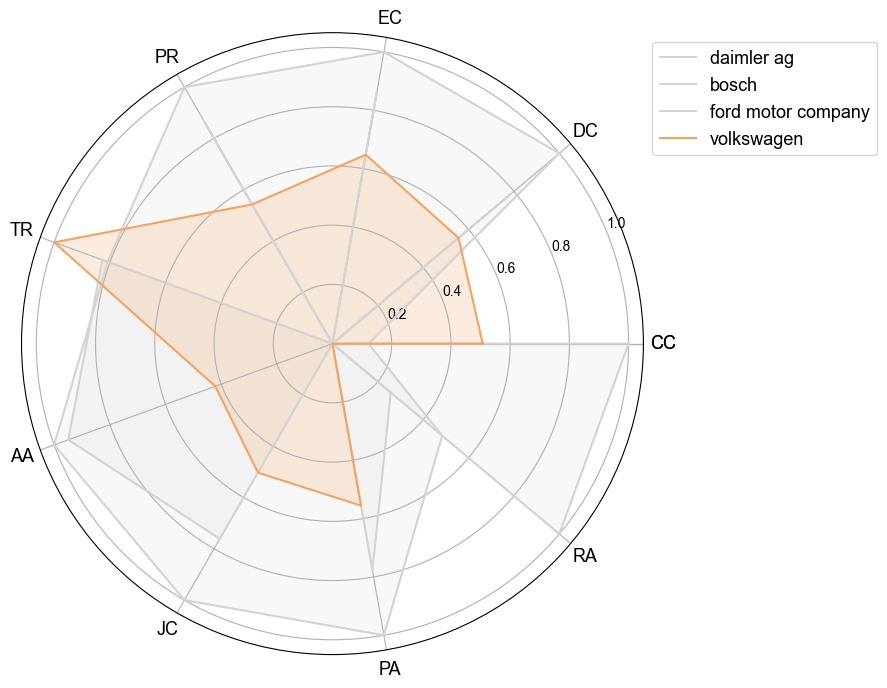

In [25]:
labels = ['CC', 'DC', 'EC', 'PR', 'TR', 'AA', 'JC', 'PA', 'RA', 'CC']
label_loc = np.linspace(start=0, stop=2*np.pi, num=len(indices_candidate))
plt.figure(figsize=(10, 7))
ax = plt.subplot(polar=True)
plt.xticks(label_loc, labels=labels, fontsize=13)
for aid, indices in indices_compare.items():
    ax.plot(label_loc, indices, label=aid2aff[aid], color='lightgray')
    ax.fill(label_loc, indices, color='silver', alpha=0.1)

ax.plot(label_loc, indices_candidate, label=aid2aff[candidate_aid], color='sandybrown')
ax.fill(label_loc, indices_candidate, color='sandybrown', alpha=0.2)

ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1), fontsize=13)
plt.tight_layout()
plt.show()

## Task 2
* Recommend collaboration research topic
* sim(target organization 1, recommended topic) + sim(target organizatio 2, recommended topic)

In [26]:
model = 'DeepWalk'
with open(f'../01.data/11.entities_{model}_latter.pkl', 'rb') as f:
    entities = pickle.load(f)

topic_vec = np.array([list(entities[str(node2idx_l[f't{tid}'])]) for tid in range(63)])
aff_vec = np.array([list(entities[str(node2idx_l[f'f{aid}'])]) for aid in aff_list_l])

aff1, aff2 = 22, 2832
latter_for_two = df_l.loc[df_l.affiliation_id.isin([aff1, aff2])].topic_id.unique()

topic_sim_1 = cosine_similarity(aff_vec[aff_list_l.index(aff1)].reshape(1,-1), topic_vec)[0]
topic_sim_2 = cosine_similarity(aff_vec[aff_list_l.index(aff2)].reshape(1,-1), topic_vec)[0]

total_sim = topic_sim_1 + topic_sim_2
for idx in np.argsort(total_sim)[::-1]:
    if idx not in latter_for_two:
        print(f'[New] {total_sim[idx]:.4f} Topic {idx+1} {topic_labels.Abbreviation[idx]}')
    else:
        print(f'[Old] {total_sim[idx]:.4f} Topic {idx+1} {topic_labels.Abbreviation[idx]}')

[Old] 0.5903 Topic 11 EV Batt Mgmt
[Old] 0.4535 Topic 1 Li Batt Tech
[Old] 0.4097 Topic 23 PEM Fuel Cell
[Old] 0.4071 Topic 43 Bifunct O2 Reduct Cat
[Old] 0.3661 Topic 37 Hybrid Veh Mgmt
[Old] 0.3065 Topic 14 Overall Water Split
[Old] 0.3039 Topic 2 Renew Energ Econ
[Old] 0.2950 Topic 55 Wave Energ Conv
[Old] 0.2941 Topic 59 SOFC Sys Anal
[Old] 0.2893 Topic 50 Vanad Flow Batt
[Old] 0.2861 Topic 54 Geotherm Sys Model
[Old] 0.2791 Topic 52 Membr Fuel Cell
[Old] 0.2650 Topic 63 H2 Store Mat
[Old] 0.2555 Topic 56 EV Charg Infra
[Old] 0.2534 Topic 4 Waste Heat Rec
[Old] 0.2527 Topic 51 CO2 Capt Tech
[Old] 0.2463 Topic 61 PV Store Integr
[Old] 0.2454 Topic 53 Chem Loop Proc
[Old] 0.2295 Topic 29 Heat Pump Sys
[Old] 0.2140 Topic 34 Thermoelec Waste Rec
[Old] 0.2093 Topic 3 Perovsk Sol Cells
[Old] 0.2087 Topic 24 Air Batt O2 Reduct
[Old] 0.2002 Topic 8 Diesel Eng Emiss
[Old] 0.1948 Topic 46 Mix Matrix Membr
[Old] 0.1939 Topic 9 Anaerob Biogas Prod
[Old] 0.1936 Topic 12 Renew Energ Sys
[Old] 0.

In [27]:
candidate_tid = 42  # select candidate topic id

### Publications

In [28]:
df_total = pd.concat([df_f, df_l])
len(df_papers.loc[df_papers.paper_id.isin(df_total.loc[df_total.topic_id==candidate_tid].paper_id.unique())])

894

In [29]:
df_total = pd.concat([df_f, df_l])
df_papers.loc[df_papers.paper_id.isin(df_total.loc[df_total.topic_id==candidate_tid].paper_id.unique())]['Times Cited, All Databases'].sum()

32134

In [30]:
# top-cited articles
df_papers.loc[df_papers.paper_id.isin(set(df_f.loc[df_f.topic_id==candidate_tid].paper_id.unique())|set(df_l.loc[df_l.topic_id==candidate_tid].paper_id.unique()))].sort_values('Times Cited, All Databases', ascending=False)[['Source Title', 'Article Title', 'Publication Year', 'Times Cited, All Databases']]

,Source Title,Article Title,Publication Year,"Times Cited, All Databases"
94196,NATURE ENERGY,Multicomponent electrocatalyst with ultralow P...,2018,480
94008,NATURE ENERGY,In situ Raman spectroscopic evidence for oxyge...,2019,405
36056,ADVANCED ENERGY MATERIALS,Engineering Surface Amine Modifiers of Ultrasm...,2018,379
94070,NATURE ENERGY,Continuous production of pure liquid fuel solu...,2019,370
27166,ENERGY & ENVIRONMENTAL SCIENCE,Understanding cation effects in electrochemica...,2019,356
...,...,...,...,...
23809,JOURNAL OF MATERIALS CHEMISTRY A,The stabilization of supported Au nanoparticle...,2021,0
24482,JOURNAL OF MATERIALS CHEMISTRY A,Electroreduction of CO2 to CO over wide potent...,2022,0
62593,MATERIALS TODAY ENERGY,Selective exposure of platinum catalyst embedd...,2019,0
88913,CELL REPORTS PHYSICAL SCIENCE,Salt aqua regia as a green solvent for recover...,2022,0


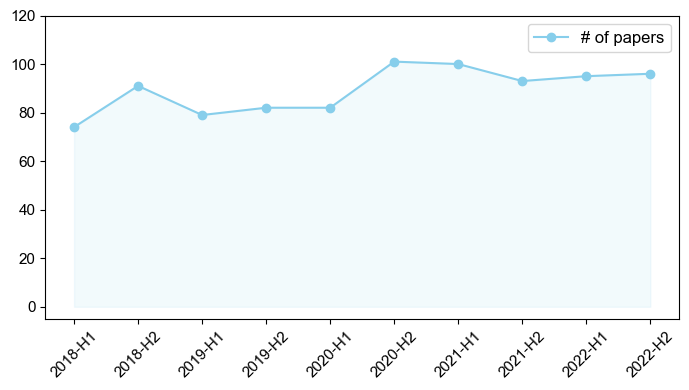

In [31]:
years = [2018, 2019, 2020, 2021, 2022]
monthes = [['JAN','FEB','MAR','APR','MAY','JUN'], ['JUL','AUG','SEP','OCT','NOV','DEC']]

timestamp = []
data = []
for y in years:
    for q, m in enumerate(monthes):
        target_papers = df_papers.loc[df_papers.paper_id.isin(df_total.loc[df_total.topic_id==candidate_tid].paper_id.unique())].loc[df_papers['Publication Year']==y].loc[df_papers['Publication Month'].isin(m)].paper_id.unique()
        data.append(len(target_papers))
        timestamp.append(f'{y}-H{q+1}')
plt.figure(figsize=(7,4))
plt.plot(timestamp, data, label='# of papers', marker='o', color='skyblue')
plt.fill_between(timestamp, data, color='skyblue', alpha=0.1)
plt.legend(fontsize=12)
plt.yticks([0, 20, 40, 60, 80, 100, 120], fontsize=11)
plt.xticks(rotation=45, fontsize=11)
plt.tight_layout()
plt.show()

### Key phrases
* Before analyzing key phrases, noun phrases for each document should be extracted using spacy (https://spacy.io/).
* In this code, we assumed that the key phrases and their document frequencies are already extracted.

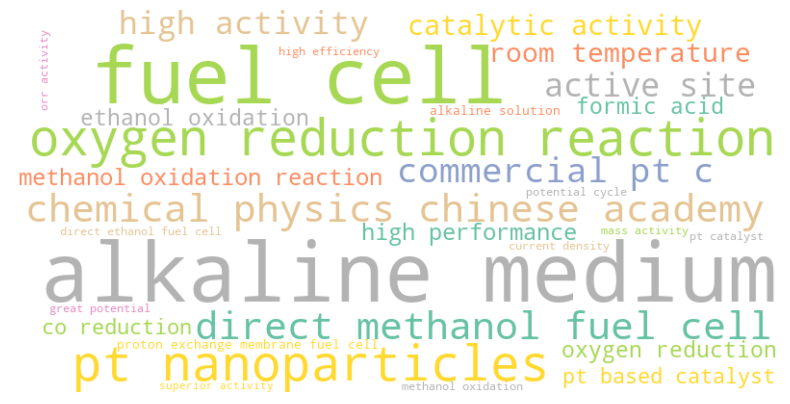

In [32]:
# prepare noun phrase - frequency dataset
word_list = [['alkaline medium' ,32],
['fuel cell' ,28],
['oxygen reduction reaction' ,22],
['pt nanoparticles' ,21],
['chemical physics chinese academy' ,21],
['direct methanol fuel cell' ,21],
['commercial pt c' ,20],
['active site' ,18],
['high activity' ,17],
['catalytic activity' ,14],
['room temperature' ,13],
['methanol oxidation reaction' ,11],
['high performance' ,11],
['ethanol oxidation' ,11],
['formic acid' ,11],
['oxygen reduction' ,11],
['co reduction' ,10],
['pt based catalyst' ,10],
['proton exchange membrane fuel cell' ,10],
['alkaline solution' ,10],
['direct ethanol fuel cell' ,9],
['mass activity' ,9],
['potential cycle' ,9],
['current density' ,9],
['methanol oxidation' ,9],
['orr activity' ,9],
['high efficiency' ,9],
['pt catalyst' ,9],
['great potential' ,9],
['superior activity' ,8]]

word_freq = {item[0]: item[1] for item in word_list}

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Set2').generate_from_frequencies(word_freq)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

### Network indices

In [33]:
cc_list = [CC[f't{tid}'] for tid in range(63)]
dc_list = [DC[f't{tid}'] for tid in range(63)]
ec_list = [EC[f't{tid}'] for tid in range(63)]
pr_list = [PR[f't{tid}'] for tid in range(63)]
tr_list = [TR[f't{tid}'] for tid in range(63)]

In [34]:
aa_list = [list(nx.adamic_adar_index(G_l, ebunch=[(target, f't{tid}')]))[0][2] for tid in range(63)]
jc_list = [list(nx.jaccard_coefficient(G_l, ebunch=[(target, f't{tid}')]))[0][2] for tid in range(63)]
pa_list = [list(nx.preferential_attachment(G_l, ebunch=[(target, f't{tid}')]))[0][2] for tid in range(63)]
ra_list = [list(nx.resource_allocation_index(G_l, ebunch=[(target, f't{tid}')]))[0][2] for tid in range(63)]

aa_list_c = [list(nx.adamic_adar_index(G_l, ebunch=[(candidate, f't{tid}')]))[0][2] for tid in range(63)]
jc_list_c = [list(nx.jaccard_coefficient(G_l, ebunch=[(candidate, f't{tid}')]))[0][2] for tid in range(63)]
pa_list_c = [list(nx.preferential_attachment(G_l, ebunch=[(candidate, f't{tid}')]))[0][2] for tid in range(63)]
ra_list_c = [list(nx.resource_allocation_index(G_l, ebunch=[(candidate, f't{tid}')]))[0][2] for tid in range(63)]

In [35]:
topic_indices = {}
for tid in np.argsort(cosine_similarity(topic_vec[candidate_tid].reshape(1,-1), topic_vec)[0])[::-1][:5]:
    tid = f't{tid}'
    
    indices_org1 = [
        (CC[tid]-min(cc_list))/(max(cc_list)-min(cc_list)),
        (DC[tid]-min(dc_list))/(max(dc_list)-min(dc_list)),
        (EC[tid]-min(ec_list))/(max(ec_list)-min(ec_list)),
        (PR[tid]-min(pr_list))/(max(pr_list)-min(pr_list)),
        (TR[tid]-min(tr_list))/(max(tr_list)-min(tr_list)),
        (list(nx.adamic_adar_index(G_l, ebunch=[(tid, target)]))[0][2]-min(aa_list))/(max(aa_list)-min(aa_list)),
        (list(nx.jaccard_coefficient(G_l, ebunch=[(tid, target)]))[0][2]-min(jc_list))/(max(jc_list)-min(jc_list)),
        (list(nx.preferential_attachment(G_l, ebunch=[(tid, target)]))[0][2]-min(pa_list))/(max(pa_list)-min(pa_list)),
        (list(nx.resource_allocation_index(G_l, ebunch=[(tid, target)]))[0][2]-min(ra_list))/(max(ra_list)-min(ra_list)),
        (CC[tid]-min(cc_list))/(max(cc_list)-min(cc_list)),
    ]
    
    indices_org2 = [
        (CC[tid]-min(cc_list))/(max(cc_list)-min(cc_list)),
        (DC[tid]-min(dc_list))/(max(dc_list)-min(dc_list)),
        (EC[tid]-min(ec_list))/(max(ec_list)-min(ec_list)),
        (PR[tid]-min(pr_list))/(max(pr_list)-min(pr_list)),
        (TR[tid]-min(tr_list))/(max(tr_list)-min(tr_list)),
        (list(nx.adamic_adar_index(G_l, ebunch=[(tid, candidate)]))[0][2]-min(aa_list_c))/(max(aa_list_c)-min(aa_list_c)),
        (list(nx.jaccard_coefficient(G_l, ebunch=[(tid, candidate)]))[0][2]-min(jc_list_c))/(max(jc_list_c)-min(jc_list_c)),
        (list(nx.preferential_attachment(G_l, ebunch=[(tid, candidate)]))[0][2]-min(pa_list_c))/(max(pa_list_c)-min(pa_list_c)),
        (list(nx.resource_allocation_index(G_l, ebunch=[(tid, candidate)]))[0][2]-min(ra_list_c))/(max(ra_list_c)-min(ra_list_c)),
        (CC[tid]-min(cc_list))/(max(cc_list)-min(cc_list)),
    ]
    
    topic_indices[int(tid[1:])] = [(indices_org1[i]+indices_org2[i])/2 for i in range(len(indices_org1))]

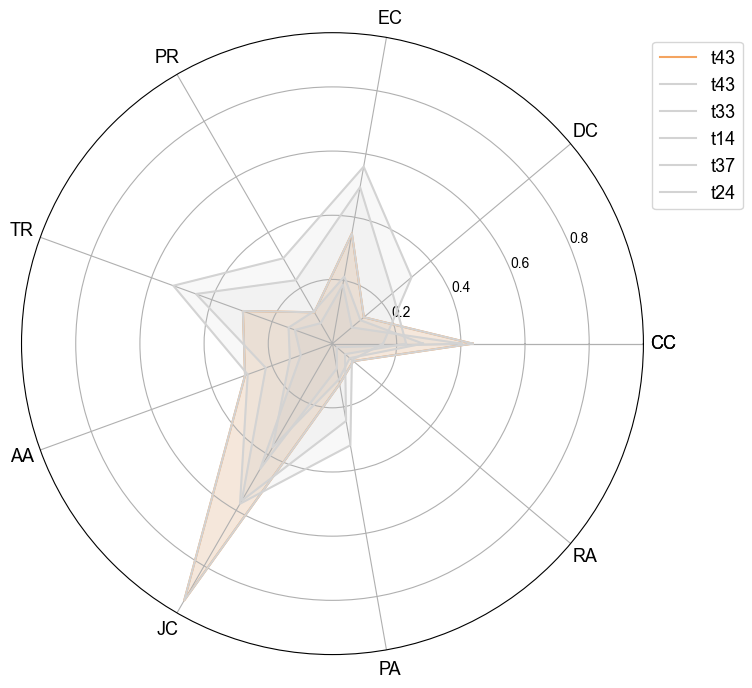

In [36]:
labels = ['CC', 'DC', 'EC', 'PR', 'TR', 'AA', 'JC', 'PA', 'RA', 'CC']
label_loc = np.linspace(start=0, stop=2*np.pi, num=len(topic_indices[candidate_tid]))
plt.figure(figsize=(8, 7))
ax = plt.subplot(polar=True)
plt.xticks(label_loc, labels=labels, fontsize=13)
for i, (tid, indices) in enumerate(topic_indices.items()):
    if i==0:
        ax.plot(label_loc, indices, label=f't{tid+1}', color='sandybrown')
        ax.fill(label_loc, indices, color='sandybrown', alpha=0.2)
    ax.plot(label_loc, indices, label=f't{tid+1}', color='lightgray')
    ax.fill(label_loc, indices, color='silver', alpha=0.1)

ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1), fontsize=13)
plt.tight_layout()
plt.show()

### Key organizations

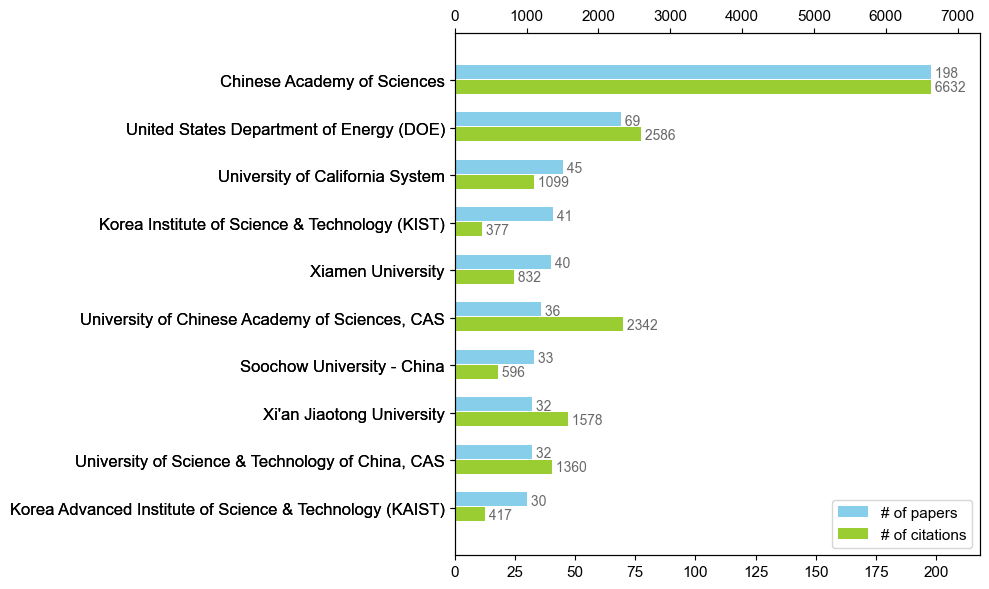

In [37]:
from collections import Counter
data = []
for aff, cnt in Counter('; '.join(df_papers.loc[df_papers.paper_id.isin(df_total.loc[df_total.topic_id==candidate_tid].paper_id.unique())].Affiliations.values).split('; ')).items():
    data.append([aff, cnt])
df_major_aff = pd.DataFrame(data, columns=['affiliation', 'n_papers'])
df_major_aff.sort_values('n_papers', ascending=False, inplace=True)
df_major_aff = df_major_aff.iloc[:10]

data_cit = [0 for _ in range(10)]
for affiliations, cit in df_papers[['Affiliations', 'Times Cited, All Databases']].dropna().values:
    for i, aff in enumerate(df_major_aff.affiliation.values):
            if aff in affiliations:
                data_cit[i] += 1
df_major_aff['n_citations'] = data_cit
df_major_aff = df_major_aff.set_index(keys='affiliation')
df_major_aff.sort_values('n_papers', ascending=True, inplace=True)

ax = df_major_aff['n_papers'].plot.barh(stacked=False, figsize=(10, 6), position=-0.1, width=0.3, color='skyblue', label='# of papers')
ax2 = ax.twiny()
df_major_aff['n_citations'].plot.barh(ax=ax2, color='yellowgreen', position=0.95, width=0.3, label='# of citations')

xlim1 = ax.get_xlim()
xlim2 = ax2.get_xlim()
ax.set_xlim(xlim1[0], xlim1[1] * 1.05)  # Increase the upper limit by 10%
ax2.set_xlim(xlim2[0], xlim2[1] * 1.05)  # Increase the upper limit by 10%

ax.set_ylim(-1, len(df_major_aff))


ax.set_ylabel('')
ax2.set_ylabel('')
ax.grid(False)
ax2.grid(False)
ax.tick_params(axis='x', which='major', labelsize=11)
ax.tick_params(axis='y', which='major', labelsize=12)
ax2.tick_params(axis='x', which='major', labelsize=11)
ax2.tick_params(axis='y', which='major', labelsize=12)

for i, (value1) in enumerate(df_major_aff['n_papers']):
    ax.text(value1, i, f' {value1}', va='bottom', ha='left', color='dimgray', fontsize=10)

for i, (value1) in enumerate(df_major_aff['n_citations']):
    ax2.text(value1, i, f' {value1}', va='top', ha='left', color='dimgray', fontsize=10)
    
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='best', fontsize=11)
plt.tight_layout()
plt.show()